# Spam text classification

**Credit: [AITS Cainvas Community](https://discord.gg/x6xn39u)**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/spam_text.gif)

*Photo by [Emanuele Colombo](https://dribbble.com/shots/3045457-Spam) on [Dribbble](https://dribbble.com)*

Identifying whether the given text is spam or not (ham). This helps in filtering through unnecessary text content and keep us focussed on the important information.

# Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import re
import matplotlib.pyplot as plt
from keras import layers, optimizers, losses, callbacks, models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import random
from wordcloud import WordCloud
# stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jupyter-
[nltk_data]     gunjan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# The dataset

[On Kaggle](https://www.kaggle.com/team-ai/spam-text-message-classification) by [Team AI](https://www.team-ai.com/)

> Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011. [Website](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/) | [UCI](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)

The dataset is a CSV file with messages falling into one of two categories -  ham and spam.

In [2]:
df = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/SPAM_text_message_20170820_-_Data.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# Preprocessing

## Dropping repeated rows

In [3]:
# Distribution of score values
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [4]:
df = df.drop_duplicates()
df['Category'].value_counts()

ham     4516
spam     641
Name: Category, dtype: int64

It is not a balanced dataset but we will go forward with it.

## Encoding the category values

In [5]:
# Labels as 1 - spam or 0 - ham
df['Category'] = df['Category'].apply(lambda x : 1 if x == 'spam' else 0)

df

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


## Data cleaning

In [6]:
# Remove html tags
def removeHTML(sentence):
    regex = re.compile('<.*?>')
    return re.sub(regex, ' ', sentence)

# Remove URLs
def removeURL(sentence):
    regex = re.compile('http[s]?://\S+')
    return re.sub(regex, ' ', sentence)

# remove numbers, punctuation and any special characters (keep only alphabets)
def onlyAlphabets(sentence):
    regex = re.compile('[^a-zA-Z]')
    return re.sub(regex, ' ', sentence)

def removeRecurring(sentence):
    return re.sub(r'(.)\1{2,}', r'\1', sentence)

# Defining stopwords
stop = nltk.corpus.stopwords.words('english')

In [7]:
sno = nltk.stem.SnowballStemmer('english')    # Initializing stemmer
spam = []    # All words in positive reviews
ham = []    # All words in negative reviews
all_sentences = []    # All cleaned sentences


for x in range(len(df['Message'].values)):
    review = df['Message'].values[x]
    rating = df['Category'].values[x]

    cleaned_sentence = []
    sentence = removeURL(review) 
    sentence = removeHTML(sentence)
    sentence = onlyAlphabets(sentence)
    sentence = sentence.lower()   

    sentence = removeRecurring(sentence)  

    for word in sentence.split():
        #if word not in stop:
            stemmed = sno.stem(word)
            cleaned_sentence.append(stemmed)
            
            if rating == 1 :
                spam.append(stemmed)
            else:
                ham.append(stemmed)

    all_sentences.append(' '.join(cleaned_sentence))

# add as column in dataframe
df['Cleaned'] = all_sentences

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Visualization

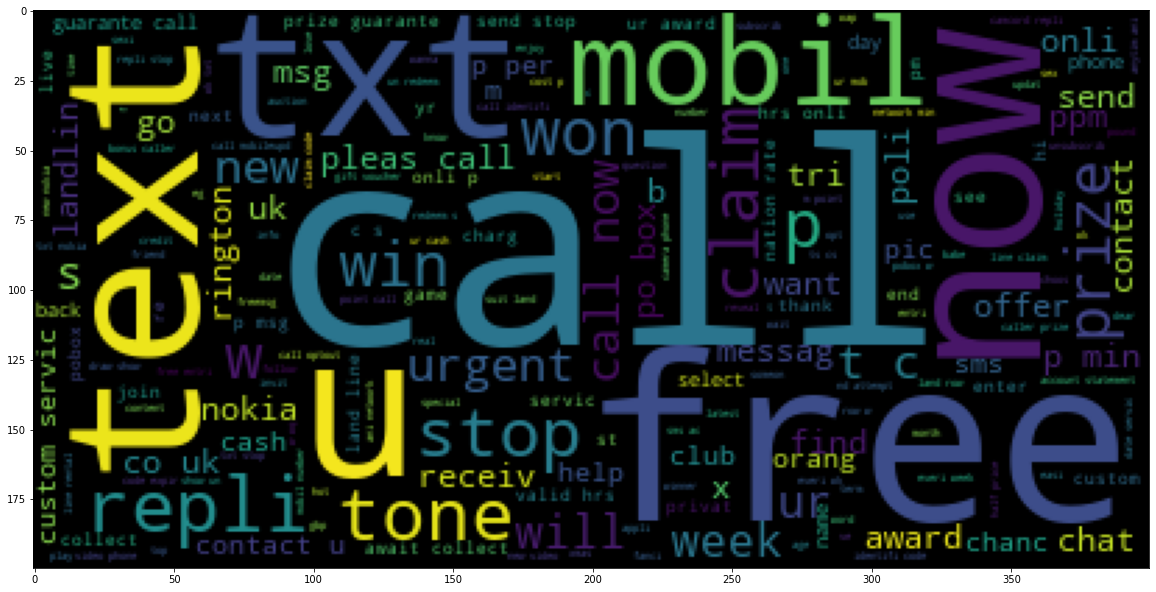

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(' '.join(spam)))

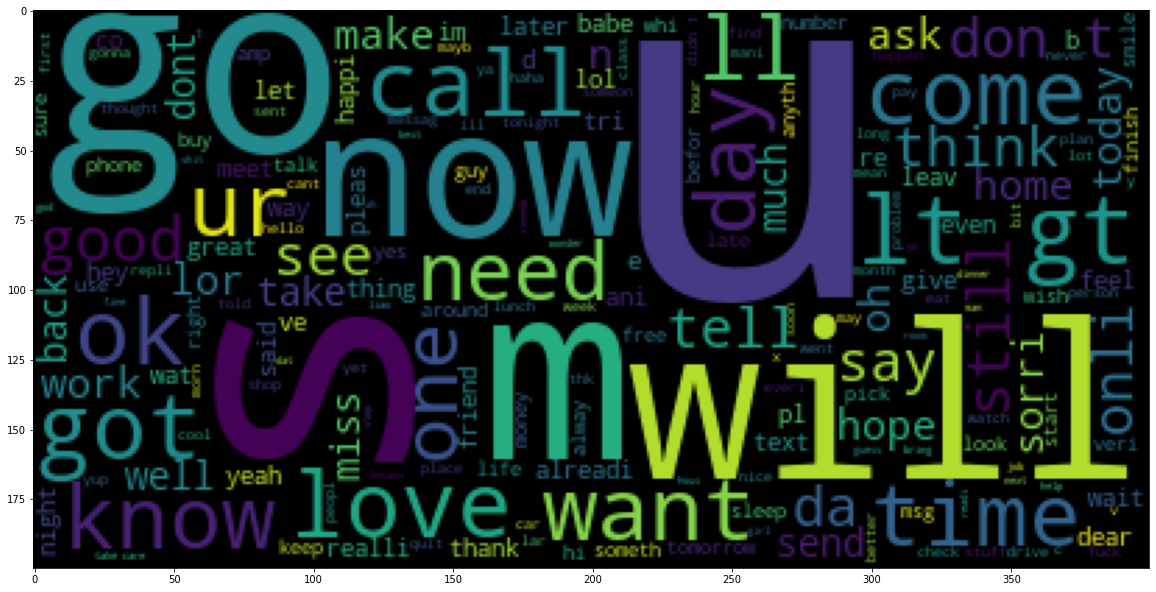

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(' '.join(ham)))

# Preprocessing (continued...)

## Train test split

In [10]:
# Splitting into train, val and test set -- 80-10-10 split

# First, an 80-20 split
train_df, val_test_df = train_test_split(df, test_size = 0.2, random_state = 113)

# Then split the 20% into half
val_df, test_df = train_test_split(val_test_df, test_size = 0.5, random_state = 113)

print("Number of samples in...")
print("Training set: ", len(train_df))
print("Validation set: ", len(val_df))
print("Testing set: ", len(test_df)) 

Number of samples in...
Training set:  4125
Validation set:  516
Testing set:  516


## Tokenization

In [11]:
cv = CountVectorizer(ngram_range = (1,1), max_features=20000)

train_bow = cv.fit_transform(train_df['Cleaned'])
val_bow = cv.transform(val_df['Cleaned'])
test_bow = cv.transform(test_df['Cleaned'])

In [12]:
tfidf = TfidfTransformer().fit(train_bow)

train_tf = tfidf.transform(train_bow)
val_tf = tfidf.transform(val_bow)
test_tf = tfidf.transform(test_bow)

## Defining the input and output 

In [13]:
Xtrain = train_tf.toarray()
ytrain = train_df['Category']

Xval = val_tf.toarray()
yval = val_df['Category']

ytest = test_df['Category']
Xtest = test_tf.toarray()

# The model

Here we implement a model based on the frequency of different words in the sentence.

In [14]:
model = models.Sequential([
    layers.Dense(16, activation = 'relu', input_shape = Xtrain[0].shape),   
    layers.Dense(4, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

cb = [callbacks.EarlyStopping(patience = 5, restore_best_weights = True)]

In [15]:
model.compile(optimizer = optimizers.Adam(0.0001), loss = losses.BinaryCrossentropy(), metrics = ['accuracy'])

history = model.fit(Xtrain, ytrain, validation_data = (Xval, yval), epochs = 128, callbacks = cb)

Epoch 1/128
129/129 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.7496 - val_loss: 0.6886 - val_accuracy: 0.8605
Epoch 2/128
129/129 [==============================] - 0s 2ms/step - loss: 0.6859 - accuracy: 0.8817 - val_loss: 0.6836 - val_accuracy: 0.8682
Epoch 3/128
129/129 [==============================] - 0s 2ms/step - loss: 0.6803 - accuracy: 0.9076 - val_loss: 0.6774 - val_accuracy: 0.9302
Epoch 4/128
129/129 [==============================] - 0s 2ms/step - loss: 0.6736 - accuracy: 0.9554 - val_loss: 0.6702 - val_accuracy: 0.9671
Epoch 5/128
129/129 [==============================] - 0s 2ms/step - loss: 0.6661 - accuracy: 0.9792 - val_loss: 0.6624 - val_accuracy: 0.9806
Epoch 6/128
129/129 [==============================] - 0s 2ms/step - loss: 0.6581 - accuracy: 0.9872 - val_loss: 0.6542 - val_accuracy: 0.9826
Epoch 7/128
129/129 [==============================] - 0s 2ms/step - loss: 0.6498 - accuracy: 0.9893 - val_loss: 0.6459 - val_accuracy: 0.9826

In [16]:
model.evaluate(Xtest, ytest)

print("F1 score - ", f1_score(ytest, (model.predict(Xtest)>0.5).astype('int')))

17/17 [==============================] - 0s 1ms/step - loss: 0.2373 - accuracy: 0.9612
F1 score -  0.8387096774193549


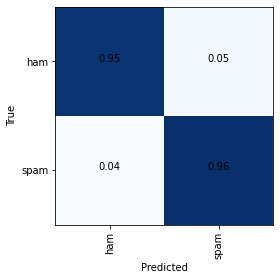

In [17]:
ytest_val = ['spam' if i == 1 else 'ham' for i in ytest]
ypred = (model.predict(Xtest)>0.5).astype('int')
ypred_val = ['spam' if i == 1 else 'ham' for i in ypred]

cm = confusion_matrix(ytest_val, ypred_val, labels=['spam', 'ham'])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot(111)

for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):   
        ax.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="black")

columns = ['ham', 'spam']

_ = ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_xticks(range(2))
ax.set_yticks(range(2))
ax.set_xticklabels(columns, rotation = 90)
ax.set_yticklabels(columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

A significant percentage of the ham messages are classified as spam. This can be improved with a larger dataset that includes more spam samples.

# Plotting the metrics

In [18]:
def plot(history, variable, variable2):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable2])), history[variable2])
    plt.title(variable)

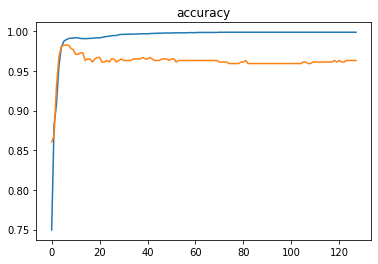

In [19]:
plot(history.history, "accuracy", 'val_accuracy')

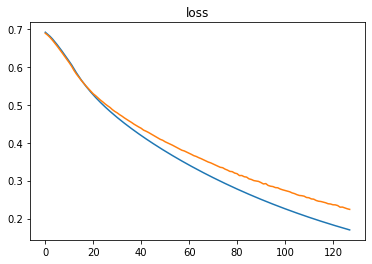

In [20]:
plot(history.history, "loss", "val_loss")

# Prediction

In [21]:
x = np.random.randint(0, Xtest.shape[0] - 1)

sentence = test_df['Message'].values[x]
print("Sentence: ", sentence)

cleaned_sentence = []
sentence = removeURL(sentence) 
sentence = removeHTML(sentence)
sentence = onlyAlphabets(sentence) 
sentence = sentence.lower() 
sentence = removeRecurring(sentence)

for word in sentence.split():
    #if word not in stop:
        stemmed = sno.stem(word)
        cleaned_sentence.append(stemmed)

sentence = [' '.join(cleaned_sentence)]
print("\nCleaned sentence: ", sentence[0])

sentence = cv.transform(sentence)
sentence = tfidf.transform(sentence)

print("\nTrue value: ", columns[test_df['Category'].values[x]])

pred = model.predict(sentence.toarray())[0][0]
print("\nPredicted value: ", columns[int(pred>0.5)], "(", pred, "-->", (pred>0.5).astype('int'), ")")

Sentence:  How many licks does it take to get to the center of a tootsie pop?

Cleaned sentence:  how mani lick doe it take to get to the center of a tootsi pop

True value:  ham

Predicted value:  ham ( 0.1734517 --> 0 )


# deepC

In [22]:
model.save('spam_text.h5')

!deepCC spam_text.h5

[INFO]
Reading [keras model] 'spam_text.h5'
[SUCCESS]
Saved 'spam_text.onnx'
[INFO]
Reading [onnx model] 'spam_text.onnx'
[INFO]
Model info:
  ir_vesion : 4
  doc       : 
[WARNING]
[ONNX]: terminal (input/output) dense_input's shape is less than 1. Changing it to 1.
[WARNING]
[ONNX]: terminal (input/output) dense_2's shape is less than 1. Changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_2) as io node.
[INFO]
Running DNNC graph sanity check ...
[SUCCESS]
Passed sanity check.
[INFO]
Writing C++ file 'spam_text_deepC/spam_text.cpp'
[INFO]
deepSea model files are ready in 'spam_text_deepC/' 
[RUNNING COMMAND]
g++ -std=c++11 -O3 -fno-rtti -fno-exceptions -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 spam_text_deepC/spam_text.cpp -o spam_text_deepC/spam_text.exe
[RUNNING COMMAND]
size "sp

In [23]:
x = np.random.randint(0, Xtest.shape[0] - 1)

sentence = test_df['Message'].values[x]
print("Sentence: ", sentence)

cleaned_sentence = []
sentence = removeURL(sentence) 
sentence = removeHTML(sentence)
sentence = onlyAlphabets(sentence) 
sentence = sentence.lower() 
sentence = removeRecurring(sentence)

for word in sentence.split():
    if word not in stop:
        stemmed = sno.stem(word)
        cleaned_sentence.append(stemmed)

sentence = [' '.join(cleaned_sentence)]
print("\nCleaned sentence: ", sentence[0])

sentence = cv.transform(sentence)
sentence = tfidf.transform(sentence)

print() 

np.savetxt('sample.data', sentence.toarray())    # xth sample into text file

# run exe with input
!spam_text_deepC/spam_text.exe sample.data

# show predicted output
nn_out = np.loadtxt('deepSea_result_1.out')

pred = (nn_out>0.5).astype('int')
print("\nPredicted value: ", columns[int(pred>0.5)], "(", pred, "-->", (pred>0.5).astype('int'), ")")

print("\nTrue value: ", columns[test_df['Category'].values[x]])

Sentence:  Mmmm ... Fuck ... Not fair ! You know my weaknesses ! *grins* *pushes you to your knee's* *exposes my belly and pulls your head to it* Don't forget ... I know yours too *wicked smile*

Cleaned sentence:  fuck fair know weak grin push knee expos belli pull head forget know wick smile

reading file sample.data.
writing file deepSea_result_1.out.

Predicted value:  ham ( 0 --> 0 )

True value:  ham
